**All imports we need**

In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import cv2
import tensorflow as tf
import keras
import keras
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D ,LSTM, CuDNNLSTM
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

**Constants**

In [2]:
TRAIN_PATH = "../input/data-imgs/train_images/train_images"
TEST_PATH = "../input/data-imgs/test_images/test_images"
TRAIN_LABEL_PATH = "../input/traincsv/train (1).csv"
num_of_classes = 6
epochs = 100
batch_size = 64
s = 128

**Get the class name from the label number**

In [3]:
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def getClassName(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x   

**Check the Size of Train images**

In [4]:
size = []
for file in  os.listdir(TRAIN_PATH) : 
        image_path = os.path.join(TRAIN_PATH, file)
        image = cv2.imread(image_path)
        size.append(image.shape)
pd.Series(size).value_counts()

(150, 150, 3)    13581
(113, 150, 3)        6
(135, 150, 3)        3
(76, 150, 3)         2
(142, 150, 3)        2
(111, 150, 3)        2
(143, 150, 3)        2
(134, 150, 3)        2
(146, 150, 3)        2
(144, 150, 3)        2
(110, 150, 3)        2
(141, 150, 3)        2
(119, 150, 3)        1
(72, 150, 3)         1
(102, 150, 3)        1
(131, 150, 3)        1
(124, 150, 3)        1
(123, 150, 3)        1
(136, 150, 3)        1
(147, 150, 3)        1
(81, 150, 3)         1
(145, 150, 3)        1
(140, 150, 3)        1
(133, 150, 3)        1
(120, 150, 3)        1
(100, 150, 3)        1
(97, 150, 3)         1
(108, 150, 3)        1
(103, 150, 3)        1
(149, 150, 3)        1
(115, 150, 3)        1
dtype: int64

most of them is (150,150,3)

**let`s check test images**

In [5]:
size = []
for file in  os.listdir(TEST_PATH) : 
        image_path = os.path.join(TEST_PATH, file)
        image = cv2.imread(image_path)
        size.append(image.shape)
pd.Series(size).value_counts()

(150, 150, 3)    3398
(136, 150, 3)       1
(111, 150, 3)       1
(105, 150, 3)       1
(131, 150, 3)       1
(81, 150, 3)        1
(123, 150, 3)       1
(113, 150, 3)       1
(149, 150, 3)       1
(108, 150, 3)       1
dtype: int64

**check the balance of the data**

3    2430
2    2366
5    2306
4    2227
1    2196
0    2102
Name: label, dtype: int64

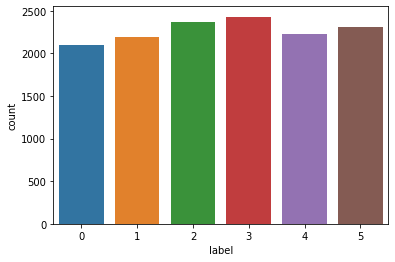

In [6]:
df = pd.read_csv(TRAIN_LABEL_PATH)
sns.countplot(x = "label" , data = df)
df['label'].value_counts()  

the data is almost balance :)

**Get the label number form the name of the image**

In [7]:
def getImgLabel(img_name):
    return df.loc[df['image_name'] == img_name].label.values[0]

**now let,s prepare the X and y data**

In [8]:
X = []
y = []
for file in  os.listdir(TRAIN_PATH) : 
        img_label = getImgLabel(file)
        image_path = os.path.join(TRAIN_PATH, file)
        image = cv2.imread(image_path)
        image_array = cv2.resize(image , (s,s))
        X.append(list(image_array))
        y.append(img_label)
                
print(f'we have {len(X)} items in X data')
print(f'we have {len(y)} items in y data')

we have 13627 items in X data
we have 13627 items in y data


**Prepare X test data**

In [9]:
X_test = []
X_imgs = []
for file in  os.listdir(TEST_PATH) : 
        X_imgs.append(file)
        image_path = os.path.join(TEST_PATH, file)
        image = cv2.imread(image_path)
        image_array = cv2.resize(image , (s,s))
        X_test.append(list(image_array))
        
print(f'we have {len(X_test)} items in X TEST')

we have 3407 items in X TEST


**Show some examples of the train images**

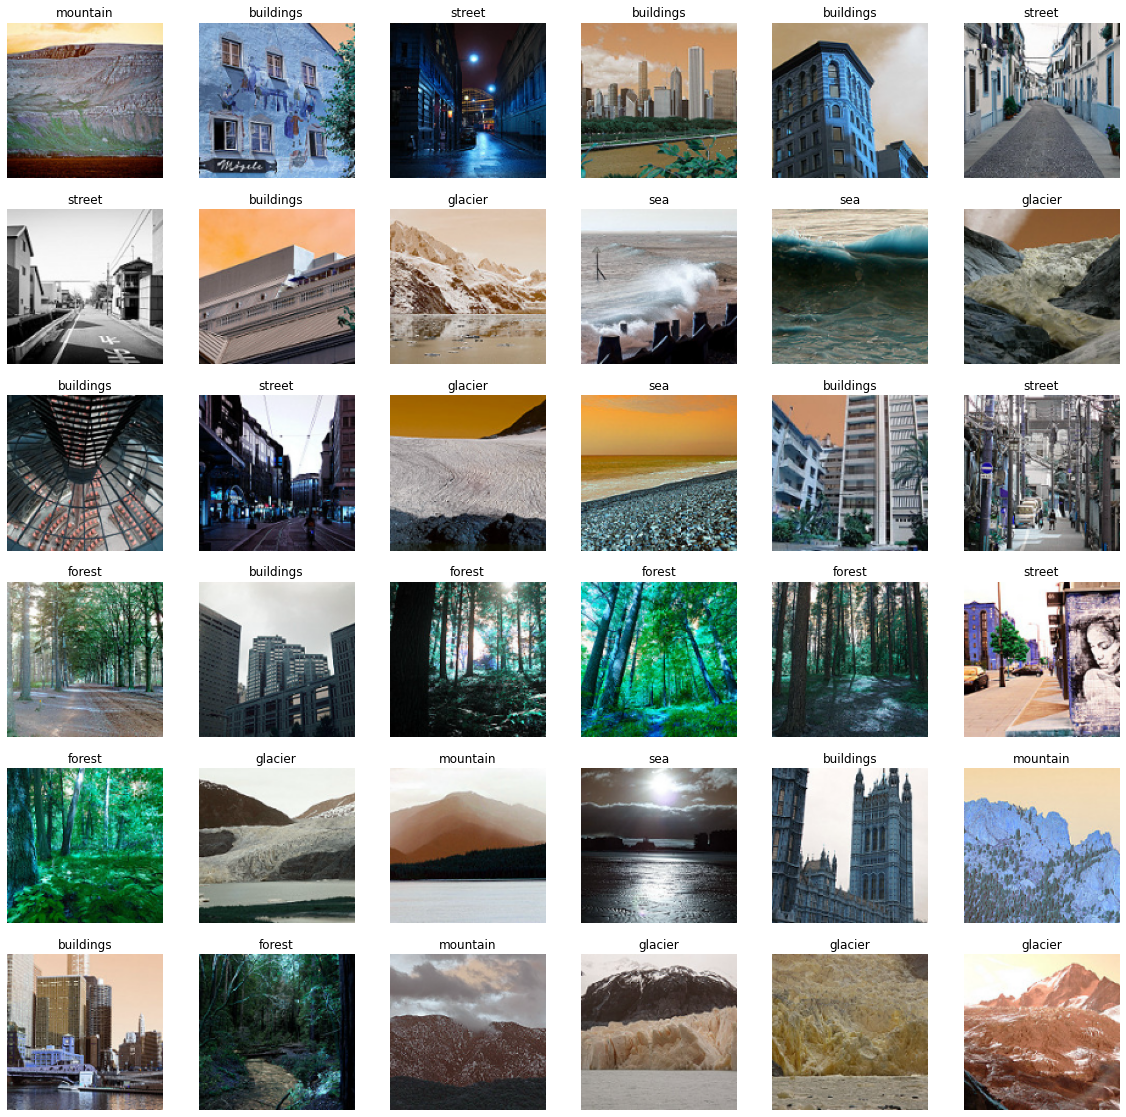

In [10]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X[i])   
    plt.axis('off')
    plt.title(getClassName(y[i]))

**Convert Data to numpy array with 4-dim ex : (12000,100,100,3)**

In [11]:
X = np.array(X)
X_test = np.array(X_test)
y = to_categorical(y, num_classes = num_of_classes)
y = np.array(y)
print(f'X_train shape  is {X.shape}')
print(f'X_test shape  is {X_test.shape}')
print(f'y_train shape  is {y.shape}')

X_train shape  is (13627, 128, 128, 3)
X_test shape  is (3407, 128, 128, 3)
y_train shape  is (13627, 6)


**Build The Model**

In [12]:
KerasModel = keras.models.Sequential([
        keras.layers.Conv2D(200,kernel_size=(9,9),activation='relu',input_shape=(s,s,3)),
        keras.layers.Conv2D(150,kernel_size=(7,7),activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(2,2),
        keras.layers.Conv2D(120,kernel_size=(5,5),activation='relu'),    
        keras.layers.Conv2D(80,kernel_size=(3,3),activation='relu'),    
        keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(2,2),
        keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPool2D(2,2),
        keras.layers.Flatten() ,    
        keras.layers.Dense(120,activation='relu') ,
        keras.layers.BatchNormalization(),
        keras.layers.Dense(100,activation='relu') ,    
        keras.layers.Dense(64,activation='relu') ,        
        keras.layers.Dropout(rate=0.5) ,            
        keras.layers.Dense(6,activation='softmax') ,    
        ])

# KerasModel = keras.models.Sequential([
#         Conv2D(128,kernel_size=(5,5),activation='relu',input_shape=(s,s,3)),
#         keras.layers.MaxPool2D(2,2),
#         keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
#         keras.layers.MaxPool2D(2,2),
#         keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
#         keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
#         keras.layers.MaxPool2D(2,2),
#         keras.layers.Flatten() ,    
#         keras.layers.Dense(1024,activation='relu') , 
#         keras.layers.Dense(256,activation='relu') ,                   
#         keras.layers.Dense(num_of_classes,activation='softmax') ,    
#         ])

# model = Sequential()

# model.add(Conv2D(filters = 128, kernel_size = (5,5), 
#                  activation ='relu', input_shape = (s,s,3)))
# model.add(Conv2D(filters = 128, kernel_size = (5,5), 
#                  activation ='relu'))
# model.add(keras.layers.BatchNormalization())
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Conv2D(filters = 64, kernel_size = (3,3), 
#                  activation ='relu'))
# model.add(Conv2D(filters = 64, kernel_size = (3,3), 
#                  activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(Conv2D(filters = 32, kernel_size = (3,3), 
#                  activation ='relu'))
# model.add(Conv2D(filters = 32, kernel_size = (3,3), 
#                  activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(Flatten())
# model.add(Dense(1024, activation = "relu"))
# model.add(Dropout(0.2))
# model.add(keras.layers.BatchNormalization())
# model.add(Dense(256, activation = "relu"))
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  kernel_initializer='he_normal',
#                  input_shape=(s,s,3)))
# model.add(MaxPool2D((2, 2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Dropout(0.4))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(num_of_classes, activation = "softmax"))

2021-12-21 13:38:46.958785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 13:38:47.053560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 13:38:47.054268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 13:38:47.055748: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
#optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
KerasModel.compile(optimizer = "RMSprop",loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
print('Model Details are : ')
print(KerasModel.summary())

Model Details are : 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 200)     48800     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 114, 114, 150)     1470150   
_________________________________________________________________
batch_normalization (BatchNo (None, 114, 114, 150)     600       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 57, 57, 150)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 120)       450120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 51, 51, 80)        86480     
_________________________________________________________________
conv2d_4 (Conv2D)            (None,

In [15]:
X_train , x_val , y_train , y_val = train_test_split(X, y, test_size = 0.15, random_state=5)
print(f'X_train shape  is {X_train.shape}')
print(f'X_val shape  is {x_val.shape}')
print(f'y_train shape  is {y_train.shape}')
print(f'y_val shape  is {y_val.shape}')

X_train shape  is (11582, 128, 128, 3)
X_val shape  is (2045, 128, 128, 3)
y_train shape  is (11582, 6)
y_val shape  is (2045, 6)


To prevent over fitting we will stop the learning after 5 epochs and val_loss value not decreased

In [16]:
earlystop = keras.callbacks.EarlyStopping(patience=25 , restore_best_weights = True)

We will reduce the learning rate when then accuracy not increase for 3 steps

In [17]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

**check point to save the model every epoch**

In [18]:
checkPoint = keras.callbacks.ModelCheckpoint(
    filepath="./",
    save_weights_only=True,
    monitor='val_loss',mode='min')

In [19]:
callbacks = [earlystop, learning_rate_reduction , checkPoint]
#callbacks = [learning_rate_reduction , earlystop]
#callbacks = [learning_rate_reduction , checkPoint]

**Apply Data Augmention**

In [20]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

**Start fitting the Model**

In [21]:
history = KerasModel.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=callbacks)

# history = model.fit(X_train,, batch_size=batch_size,
#                               epochs = epochs, validation_data = (x_val,y_val),
#                               verbose = 1, callbacks=callbacks)
# history = KerasModel.fit(X_train,
#           y_train,
#           epochs=epochs,
#           batch_size=batch_size,
#           validation_data=(x_val,y_val),
#               verbose = 1, callbacks=callbacks)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-12-21 13:38:52.074502: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-12-21 13:38:54.326697: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


180/180 [==============================] - 156s 759ms/step - loss: 1.3011 - accuracy: 0.4931 - val_loss: 2.4571 - val_accuracy: 0.4108
Epoch 2/100
180/180 [==============================] - 122s 679ms/step - loss: 1.0421 - accuracy: 0.6035 - val_loss: 1.1866 - val_accuracy: 0.5638
Epoch 3/100
180/180 [==============================] - 122s 678ms/step - loss: 0.9413 - accuracy: 0.6519 - val_loss: 0.9020 - val_accuracy: 0.6880
Epoch 4/100
180/180 [==============================] - 122s 679ms/step - loss: 0.8517 - accuracy: 0.6966 - val_loss: 0.8607 - val_accuracy: 0.6807
Epoch 5/100
180/180 [==============================] - 122s 678ms/step - loss: 0.7846 - accuracy: 0.7231 - val_loss: 0.8566 - val_accuracy: 0.6826
Epoch 6/100
180/180 [==============================] - 122s 679ms/step - loss: 0.7329 - accuracy: 0.7457 - val_loss: 0.8064 - val_accuracy: 0.7188
Epoch 7/100
180/180 [==============================] - 122s 679ms/step - loss: 0.6989 - accuracy: 0.7578 - val_loss: 0.7584 - val_

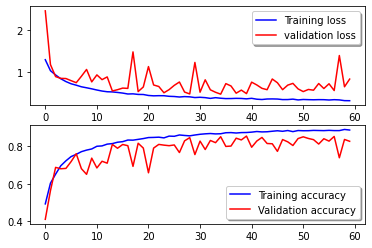

In [22]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [23]:
ModelLoss, ModelAccuracy = KerasModel.evaluate(x_val, y_val)

print('Val Loss is {}'.format(ModelLoss))
print('Val Accuracy is {}'.format(ModelAccuracy ))

64/64 [==============================] - 2s 34ms/step - loss: 0.4869 - accuracy: 0.8518
Val Loss is 0.486943781375885
Val Accuracy is 0.8518337607383728


In [24]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

(2045, 6)


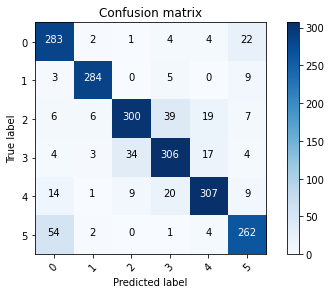

In [25]:
# Predict the values from the validation dataset
Y_pred = KerasModel.predict(x_val)
print(Y_pred.shape)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
Y_true = np.argmax(y_val,axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(6))

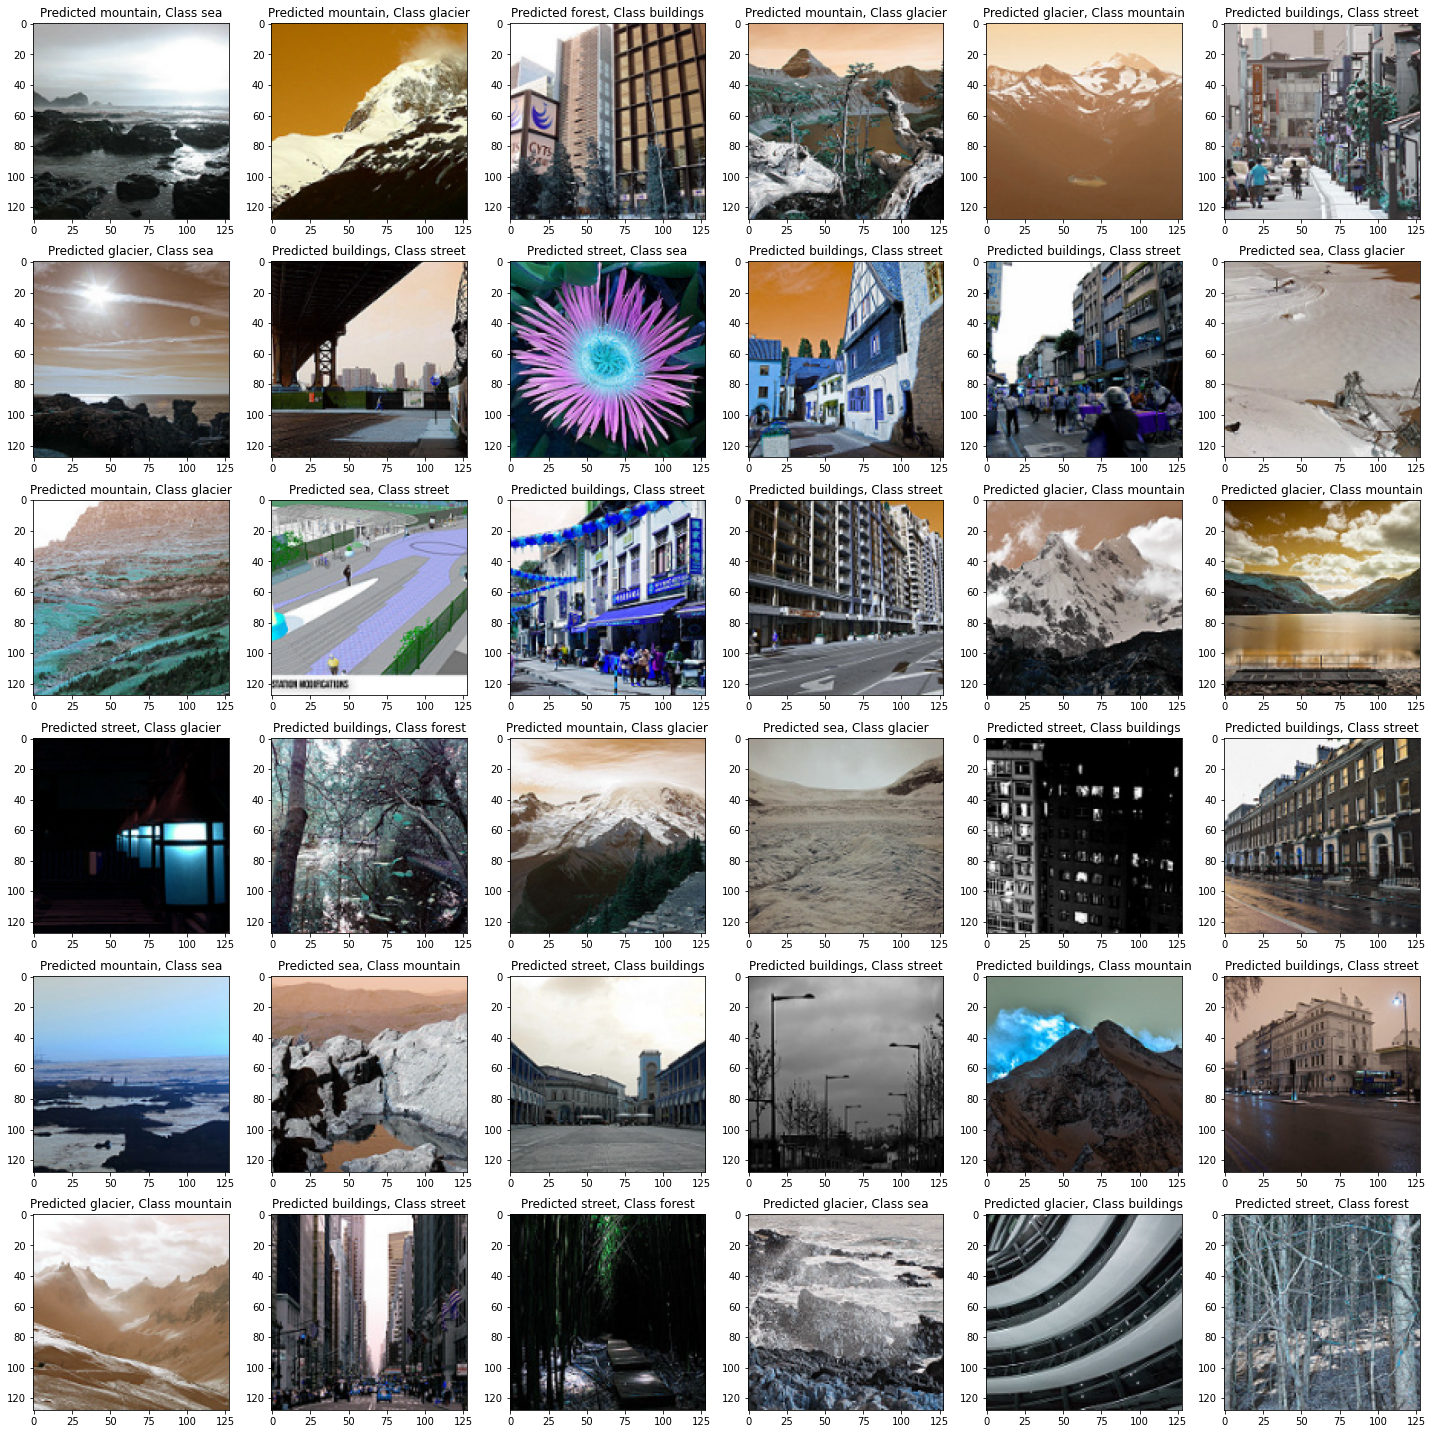

In [27]:
# for n , i in enumerate(list(np.random.randint(0,len(X_pred),36))) : 
#     plt.subplot(6,6,n+1)
#     plt.imshow(X_pred[i])    
#     plt.axis('off')
#     plt.title(getcode(np.argmax(y_result[i])))

incorrects = np.nonzero(Y_true!=Y_pred_classes)[0]
plt.figure(figsize=(20,20))
for i, incorrect in enumerate(incorrects[0:36]):
    plt.subplot(6,6,i+1)
    plt.imshow(x_val[incorrect])
    plt.title("Predicted {}, Class {}".format(getClassName(Y_pred_classes[incorrect]), getClassName(Y_true[incorrect])))
    plt.tight_layout()

In [ ]:
#History = model.fit(X_train, y_train, epochs=epochs,batch_size=batch_size,verbose=1,validation_data = (x_val,y_val),callbacks = callbacks)

In [ ]:
KerasModel.save("Final_model.h5")

In [28]:
y_pred = KerasModel.predict(X_test)

In [31]:
print(y_pred.shape)
# select the indix with the maximum probability
results = np.argmax(y_pred,axis = 1)
results = pd.Series(results,name="label")
print(results.shape)
X_imgs = pd.Series(X_imgs,name="image_name")
print(X_imgs.shape)


(3407, 6)
(3407,)
(3407,)


In [32]:
submission = pd.concat([X_imgs,results],axis = 1)
submission.to_csv("submission.csv",index=False)

**Show some of the X test images and the predicted classes of them from the model**

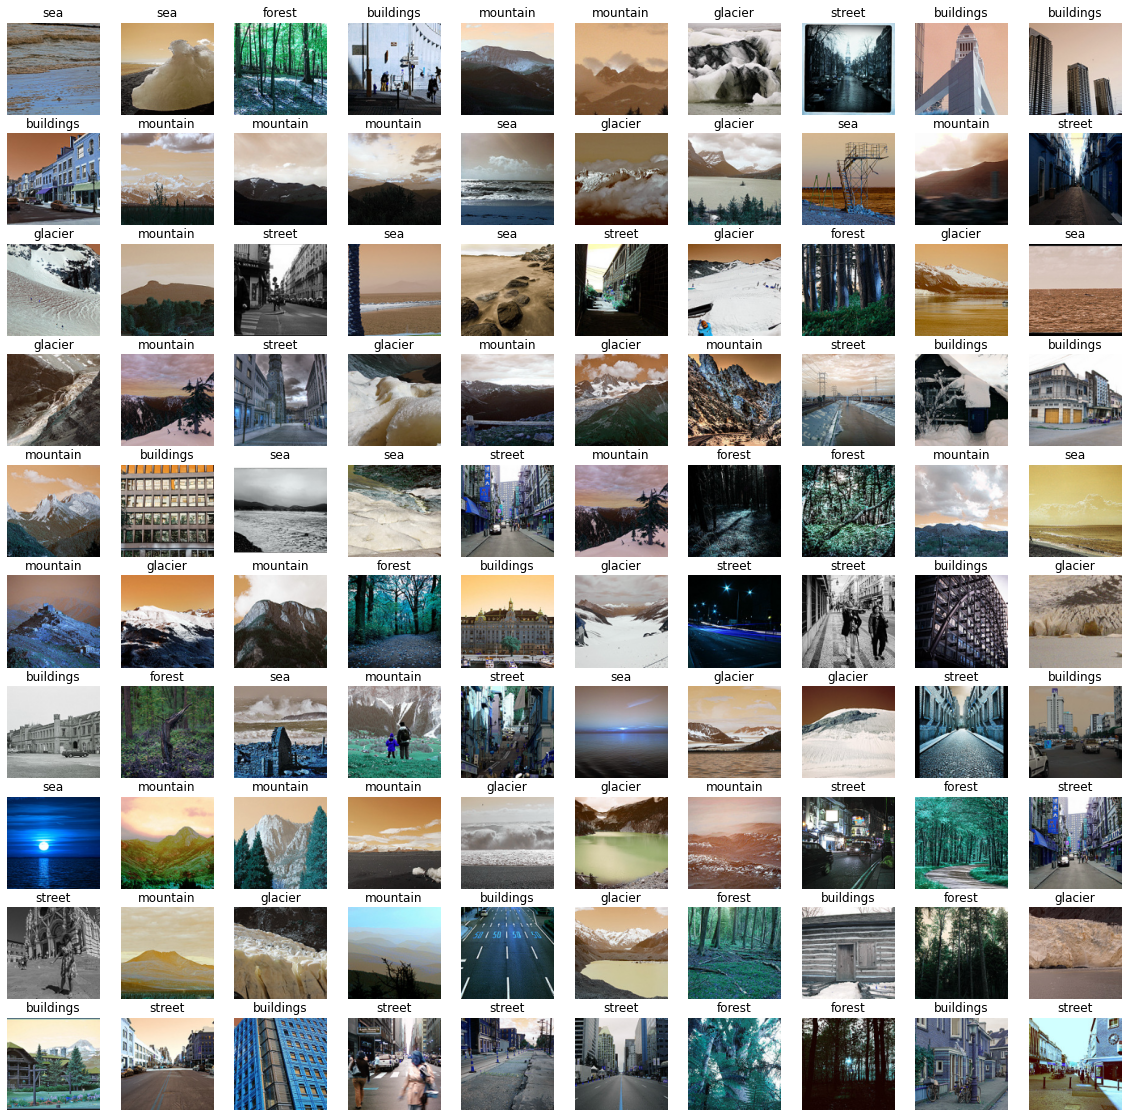

In [33]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_test),100))) : 
    plt.subplot(10,10,n+1)
    plt.imshow(X_test[i])   
    plt.axis('off')
    plt.title(getClassName(results[i]))